In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = [12,12]
#If you have problems with latex at matplotlib just comment next two lines, this might help
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))

In [3]:
a = 1
b = 19
def func(x):
    return a * (x[0]) ** 2 + b * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]
def f_grad(x):
    return np.array([2 * a * x[0] + 2 * b * (x[0] - x[1]) - 1, -2 * b * (x[0] - x[1]) - 2])

f_grad2 = np.array([[2 * (a + b), -2 * b], [-2 * b, 2 * b]])

min_point = np.linalg.solve([[2 * a + 2 * b, -2 * b], [-2 * b, 2 * b]], [1, 2])
lambdas = list(np.linalg.eig(f_grad2)[0])

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
def animate_trajectory(traj, labels, square_size, levels, min_point):
    fig, ax = plt.subplots()
    n = len(traj[0])
    def step(t):
        ax.cla()
        ax.plot(min_point[0], min_point[1], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-square_size, square_size, delta)
        y = np.arange(-square_size, square_size, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        #print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, levels, colors=['blue', 'purple', 'red'])

        colors = ['black', 'green', 'yellow', 'gray']
        for (tr, i) in zip(traj, range(len(traj))):
            ax.plot([u[0] for u in tr[:t]], [u[1] for u in tr[:t]], color=colors[i], label=labels[i])
            ax.plot([u[0] for u in tr[:t]], [u[1] for u in tr[:t]], 'o', color=colors[i])
        fix_scaling(ax)
        plt.legend()
        ax.axis('off')

    return FuncAnimation(fig, step, frames=range(n), interval=600)

In [5]:
ITERATIONS = 30
alpha = 2.0 / (sum(list(np.linalg.eig(f_grad2)[0])))
traj_opt_step = []
x_start = np.array([2, 2.8])
traj_opt_step.append(x_start.copy())
cur_x = x_start.copy()
for i in range(ITERATIONS):
    cur_x = cur_x - alpha * f_grad(cur_x)
    traj_opt_step.append(cur_x.copy())

In [6]:
#Heavy ball
alpha = 4.0 / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1])) ** 2
beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
traj_heavy_ball = []
x_start = np.array([2, 2.8])
traj_heavy_ball.append(x_start.copy())
cur_x = x_start.copy()
prev_x = x_start.copy()
for i in range(ITERATIONS):
    t = cur_x
    cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
    prev_x = t
    traj_heavy_ball.append(cur_x.copy())

In [7]:
#Chebyshev
phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
cur_gamma   = 1.0 / phi
prev_gamma  = 0
print(phi - np.sqrt(phi ** 2 - 1))
print('phi', phi)
traj_chebyshev = []
x_start = np.array([2, 2.8])
traj_chebyshev.append(x_start.copy())
cur_x = x_start.copy()
prev_x = x_start.copy()
for i in range(ITERATIONS):
    t = cur_x
    alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
    beta = cur_gamma * prev_gamma
    cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
    prev_x = t
    t = cur_gamma
    cur_gamma = 1.0 / (2 * phi - cur_gamma)
    prev_gamma = t
    traj_chebyshev.append(cur_x.copy())

0.796624263916
phi 1.02596060144


In [8]:
#Nesterov
alpha = 1 / (lambdas[0] + 1)
beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
traj_nesterov = []
x_start = np.array([2, 2.8])
traj_nesterov.append(x_start.copy())
cur_x = x_start.copy()
cur_y = x_start.copy()

for i in range(ITERATIONS):
    t = cur_x
    cur_x = cur_y - alpha * f_grad(cur_y)
    cur_y = cur_x + beta * (cur_x - t)
    traj_nesterov.append(cur_x.copy())

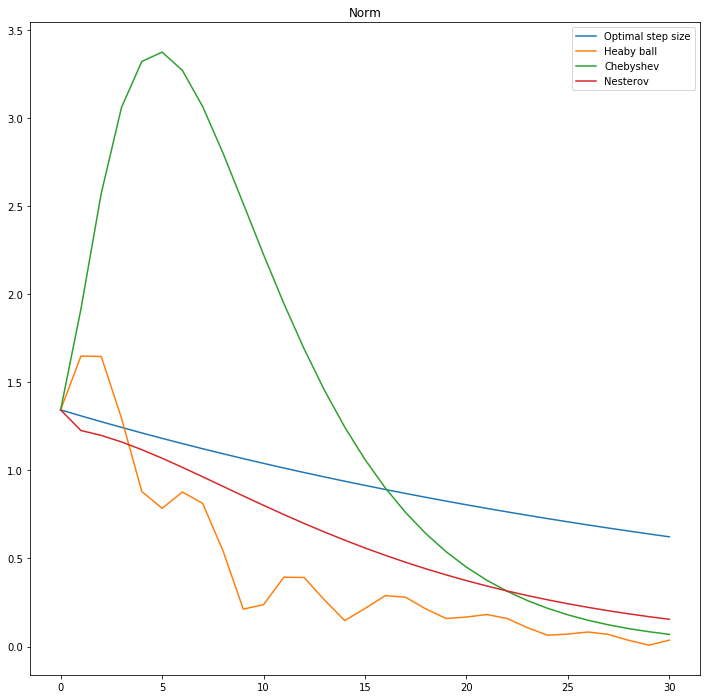

In [9]:
def norm(x):
    return np.sqrt((x[0] - min_point[0]) ** 2 + (x[1] - min_point[1]) ** 2)

plt.clf()
fig, ax = plt.subplots()
u = np.array(traj_opt_step)
ax.plot(range(ITERATIONS + 1), [norm(t) for t in u], label='Optimal step size')
u = np.array(traj_heavy_ball)
ax.plot(range(ITERATIONS + 1), [norm(t) for t in u], label='Heaby ball')
u = np.array(traj_chebyshev)
ax.plot(range(ITERATIONS + 1), [norm(t) for t in u], label='Chebyshev')
u = np.array(traj_nesterov)
ax.plot(range(ITERATIONS + 1), [norm(t) for t in u], label='Nesterov')
plt.legend()
plt.title("Norm")
plt.plot()
plt.show()

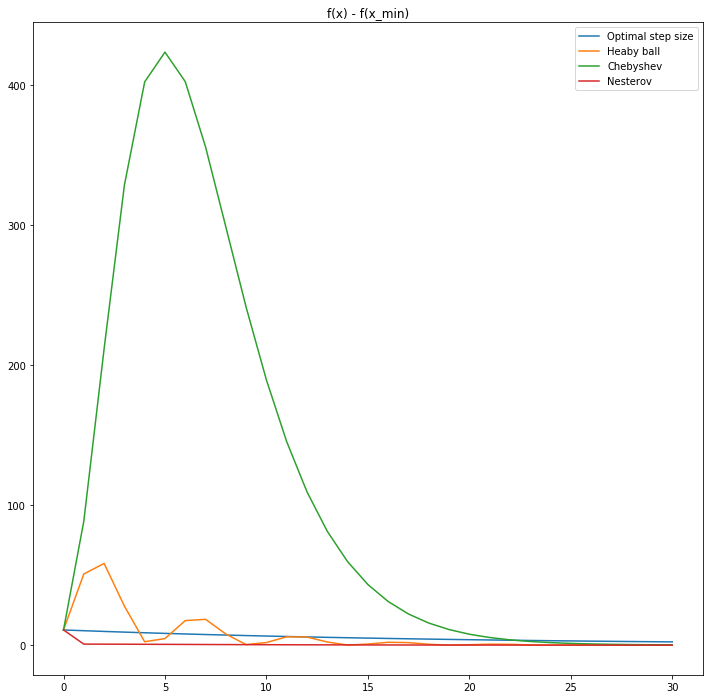

In [10]:
def diff(x):
    return func(x) - func(min_point)

plt.clf()
fig, ax = plt.subplots()
u = np.array(traj_opt_step)
ax.plot(range(ITERATIONS + 1), [diff(t) for t in u], label='Optimal step size')
u = np.array(traj_heavy_ball)
ax.plot(range(ITERATIONS + 1), [diff(t) for t in u], label='Heaby ball')
u = np.array(traj_chebyshev)
ax.plot(range(ITERATIONS + 1), [diff(t) for t in u], label='Chebyshev')
u = np.array(traj_nesterov)
ax.plot(range(ITERATIONS + 1), [diff(t) for t in u], label='Nesterov')
plt.legend()
plt.title("f(x) - f(x_min)")
plt.plot()
plt.show()

In [11]:
base_animation = animate_trajectory([traj_nesterov, traj_chebyshev, traj_heavy_ball, traj_opt_step], 
                                    ['Nesterov','Chebyshev', 'Heavy ball', 'Optimal step'], 3, [-2, 1, 4], min_point)
HTML(base_animation.to_html5_video()) 

Вторая задача.

In [12]:
import math
def func2(point):
    x, y = point[0], point[1]
    return math.exp(x + 3 * y) + math.exp(x - 3 * y) + math.exp(-x)

In [13]:
def gradf2(point):
    x, y = point[0], point[1]
    return np.array([math.exp(x + 3 * y) + math.exp(x - 3 * y) - math.exp(-x), 
                     3 * math.exp(x + 3 * y) - 3 * math.exp(x - 3 * y)])

In [14]:
def lipschitz(f):
    lip = -1
    for x1 in np.arange(-1, 1, 0.1):
        for x2 in np.arange(-1, 1, 0.1): 
            for y1 in np.arange(-1, 1, 0.1):
                for y2 in np.arange(-1, 1, 0.1):
                    dist = np.linalg.norm(np.array([x1, y1] - np.array([x2, y2])))
                    lip = max(lip, np.linalg.norm(gradf2(np.array([x1, y1])) -  gradf2(np.array([x2, y2]))) / dist)
    return lip
print(lipschitz(gradf2))

/home/andrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


405.989471624


Я нашел две какие-то точки из данного квадрата, что для них константа Липшица хотя бы 406. Попробуем теперь как-нибудь нагло оценить все сверху, чтобы получить константу не больше 406 * 3. Тогда ошибка будет не более чем в 3 раза. 
Функция, которая нам дана сколько угодно непрерывно дифференцируема. Тогда для градинета верно, что его константа липшецовости равняется максимуму производной на данном нам множестве. 
Оценим максимуму второй производной как корень из суммы квадратов. То есть:
$\frac{\partial^2f}{\partial x^2} = e^{x+3y} + e^{x-3y} + e^{-x} \leq e^4 + e^4 + e = 2e^4+e$

$\frac{\partial^2f}{\partial y^2} = 9e^{x+3y} + 9e^{x-3y} \leq 9e^4 + 9e^4 = 18e^4$

$\frac{\partial^2f}{\partial x\partial y} = 3e^{x+3y} - 3e^{x-3y} \leq 3e^4 $

Итого константа не должна превосходить $\sqrt{(2e^4+e)^2 + (18e^4)^2+2(3e^4)^2} = 1016$  Ура, получилось не очень много, нам подойдет.

In [15]:
LIP = 1016
alpha = 1.0 / LIP
traj_opt_step = []
x_start = np.array([0, 0])
traj_opt_step.append(x_start.copy())
cur_x = x_start.copy()
for i in range(ITERATIONS * 5):
    cur_x = cur_x - alpha * gradf2(cur_x)
    traj_opt_step.append(cur_x.copy())
base_animation = animate_trajectory([traj_opt_step], ['Optimal step'], 1, [3, 4, 5], np.array([-math.log(2) / 2, 0]))
HTML(base_animation.to_html5_video()) 

In [16]:
# Nesterov
alpha = 1.0 / 2
traj_nesterov = []
x_start = np.array([-1.0/2, 1.0/2])
traj_nesterov.append(x_start.copy())
cur_x = x_start.copy()
cur_y = x_start.copy()

for i in range(ITERATIONS * 5):
    t = cur_x
    cur_x = cur_y - 1.0 / LIP * gradf2(cur_y)
    alpha_next = (-alpha ** 2 + math.sqrt(alpha ** 4 + alpha ** 2)) / 2
    beta = (alpha * (1 - alpha)) / (alpha ** 2 + alpha_next)
    cur_y = cur_x + beta * (cur_x - t)
    traj_nesterov.append(cur_x.copy())
base_animation = animate_trajectory([traj_nesterov], ['Nesterov'], 1, [3, 4, 5], np.array([-math.log(2) / 2, 0]))
HTML(base_animation.to_html5_video()) 

Третья задача.

Итак, нам требуется найти коэффициенты $\alpha$, которые минимизируют сумму квадратичных отклонений. Заметим, что перед каждым $\alpha$ стоит какой-то известный коэффициент $x_i^j$. То есть на самом деле нам дали задачу линейной регрессии, только иксы в ней известны, а $\alpha$ надо найти. Решим это с помощью обращения матриц.

In [17]:
def lin_reg(n, xs, ys):
    X = []
    for x in xs:
        line = []
        for i in range(n + 1):
            line.append(x ** i)
        X.append(line)
    X = np.array(X)
    XT = np.transpose(X)
    XXT = np.dot(XT, X)
    return np.dot(np.dot(np.linalg.inv(XXT), XT), np.array(ys))

In [18]:
print(lin_reg(2, [0, 1, 2, 3, 4, 5], [1, 2, 5, 10, 17, 26]))

[  1.00000000e+00   2.04281037e-14   1.00000000e+00]


In [19]:
def best_circle(xs, ys):
    def mean(x):
        return sum(x) / len(x)
    xm = mean(xs)
    ym = mean(ys)
    u, v = [], []
    for x, y in zip(xs, ys):
        u.append(x - xm)
        v.append(y - ym)
    Su = sum(u)
    Sv = sum(v)
    Suu = sum(x ** 2 for x in u)
    Svv = sum(x ** 2 for x in v)
    Suuu = sum(x ** 3 for x in u)
    Svvv = sum(x ** 3 for x in v)
    
    Suv = sum(u[i] * v[i] for i in range(len(u)))
    
    Suuv = sum(u[i] ** 2 * v[i] for i in range(len(u)))
    Suvv = sum(u[i] * v[i] ** 2 for i in range(len(u)))
    A = np.array([[Suu, Suv], [Suv, Svv]])
    B = np.array([(Suuu + Suvv) / 2.0, (Svvv + Suuv) / 2.0])
    point_mean = np.linalg.solve(A, B)
    point = point_mean + np.array([xm, ym])
    R = math.sqrt(point_mean[0] ** 2 + point_mean[1] ** 2 + (Suu + Svv) / len(xs))
    return (point[0], point[1], R)

(-11.839285714285726, 8.4464285714285747, 14.686368280323984)
(0.0, 1.1102230246251565e-16, 1.0)


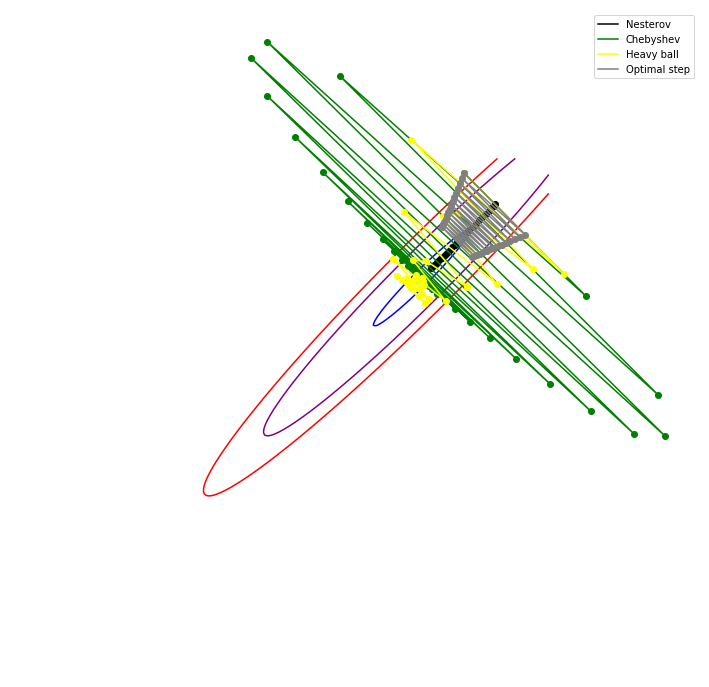

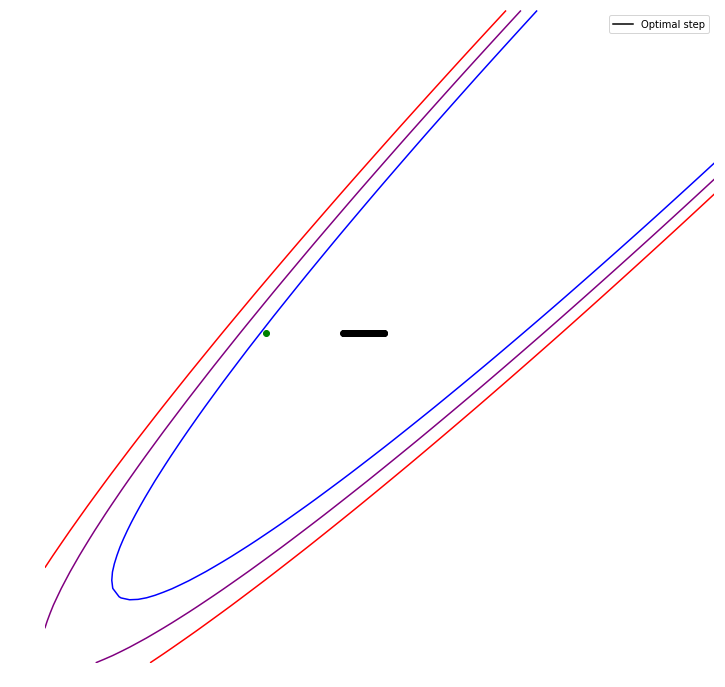

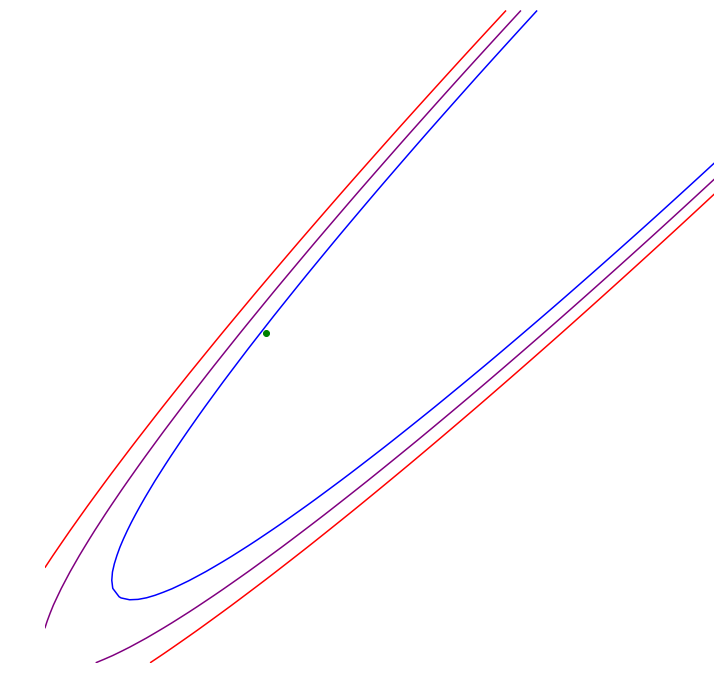

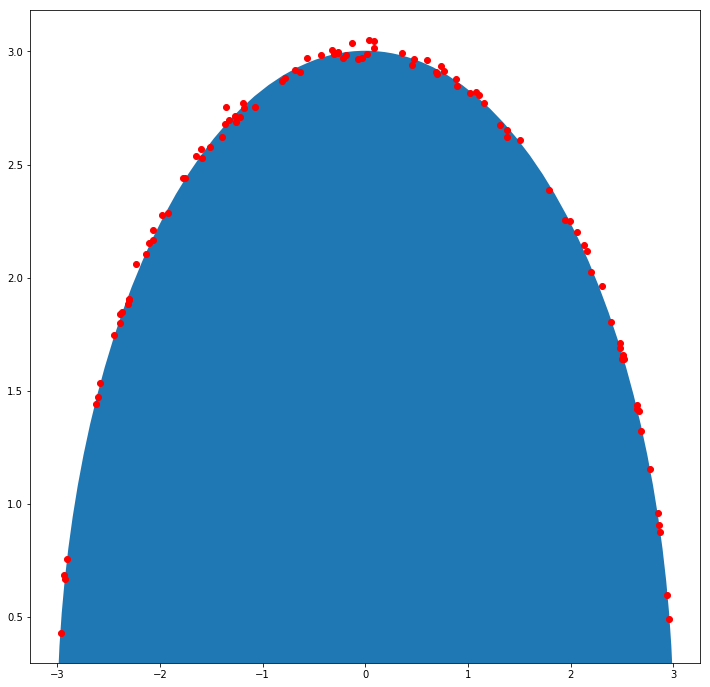

In [20]:
r = 3
xs = [np.random.uniform(-3, 3) for _ in range(100)]
ys = [math.sqrt(r ** 2 - x ** 2) + np.random.normal(0, 0.03) for x in xs]
xc, yc, R = best_circle(xs, ys)

fig, ax = plt.subplots()
circle = plt.Circle((xc, yc), R)
ax.add_artist(circle)
plt.plot(xs, ys, 'ro')
plt.show()